In [2]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()  # noqa
from umap import UMAP
from hdbscan import HDBSCAN
from python.cogtext.pubmed.preprocessing import PubMedPreprocessor

In [3]:
# Data and parameters
PUBMED = pd.read_csv('data/pubmed/abstracts.csv.gz').dropna(subset=['abstract']).reset_index()
PUBMED = PUBMED.sample(frac=0.05, random_state=0)

PUBMED = PUBMED.pipe(PubMedPreprocessor.select_relevant_journals)
PUBMED = PUBMED.pipe(PubMedPreprocessor.remove_short_abstracts)

In [21]:

# pretrained document embeddings
embeddings_file = 'models/universal-sentence-encoder-v4/abstracts_embeddings.npz'
# embeddings_file = 'models/all-MiniLM-L6-v2/abstracts_embeddings.npz'
doc_embeddings = np.load(embeddings_file)['arr_0']
doc_embeddings = doc_embeddings[PUBMED.index]
doc_embeddings = pd.DataFrame(doc_embeddings, index=PUBMED.index)
doc_embeddings['label'] = PUBMED['subcategory']

embeddings = doc_embeddings.groupby('label').max()

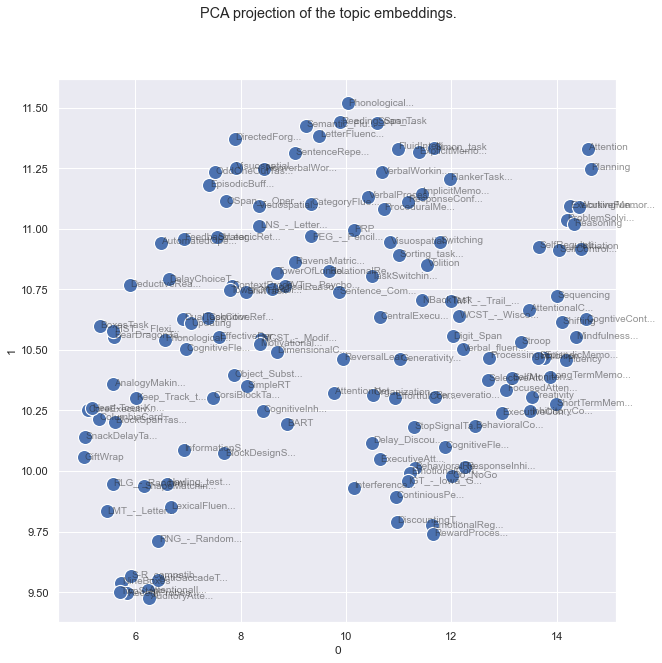

In [22]:

fig, ax = plt.subplots(1,1, figsize=(10,10))

# embeddings_2d = PCA(n_components=2, random_state=0).fit_transform(embeddings)
embeddings_2d = UMAP(n_components=2, random_state=0).fit_transform(embeddings)
embeddings_2d = pd.DataFrame(embeddings_2d, index=embeddings.index)

sns.scatterplot(data=embeddings_2d, x=0, y=1, ax=ax, palette='Accent', s=200)

for (lbl, x, y) in embeddings_2d.itertuples():
  lbl = f'{lbl[:12]}...' if len(lbl)>10 else lbl
  ax.text(x+0.01, y-np.random.random()*.01, f'{lbl}', alpha=0.5, fontsize=10)

plt.suptitle('PCA projection of the topic embeddings.')
plt.show()

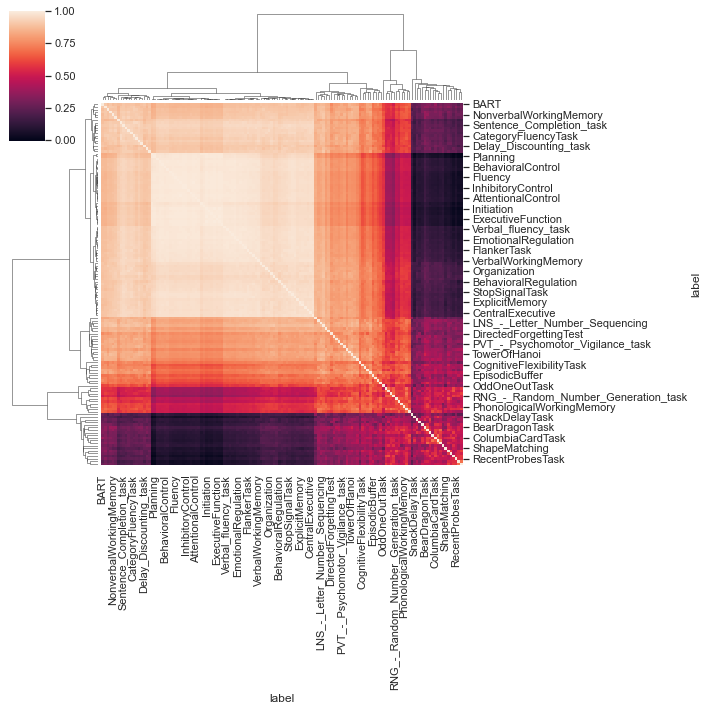

In [30]:
from sklearn.metrics.pairwise import cosine_similarity
embeddings_sim = cosine_similarity(embeddings)
embeddings_sim = pd.DataFrame(embeddings_sim, index=embeddings.index, columns=embeddings.index)
sns.clustermap(embeddings_sim)
